## adding KS4 data
1. Export spike times:
    https://codeocean.allenneuraldynamics.org/capsule/2210357/tree
    - attach new ks4 sorted asset
    - use `dump_timing_info.py` with `npc_sessions` and put .json file in `/code` 
    - run capsule to create individual session parquet files in /results, and a consolidate file
      (without spike times) at `s3://aind-scratch-data/dynamic-routing/unit-rasters-ks4/units.parquet`
    - create asset with parquet files in `/ks4` folder
2. https://codeocean.allenneuraldynamics.org/capsule/6421158/tree
    - attach new asset with ks4 session unit parquet files
    - run capsule to create R^2 values for spike count vs time
    - download `corr_values_ks4.parquet` to `\\allen\programs\mindscope\workgroups\dynamicrouting\ben`
3. run `run_unit_drift_lda.py` 
    - uses corr values and consolidated units table (for `presence_ratio`)
4. restart this notebook 

In [1]:
import pathlib
import sys
sys.path.append(str(pathlib.Path.cwd().absolute().parent))

import polars as pl
import altair as alt

from app_charts import lda_all_df, get_roc_curve_df, lda_all_ks4_df
import db_utils
from db_utils import get_df, KS4_UNITS_DF_PATH

---
Annotated units

In [ ]:
df = (
    get_df(ks4_filter=False)
    .drop_nulls('drift_rating')
    .with_columns(
        drift_rating=pl.when(pl.col("drift_rating") == db_utils.UnitDriftRating.YES)
        .then(pl.lit('drift'))
        .when(pl.col("drift_rating") == db_utils.UnitDriftRating.NO)
        .then(pl.lit('no drift'))
        .when(pl.col("drift_rating") == db_utils.UnitDriftRating.UNSURE)
        .then(pl.lit('unsure'))
    ) 
    .get_column('drift_rating')
    .value_counts(normalize=True)
    .sort('proportion')
)

display(df)
base = (
    alt.Chart(df)
    .encode(
        theta=alt.Theta("proportion:Q").stack(True),
        color=alt.Color("drift_rating").scale(scheme="blues", reverse=True).legend(None),
        tooltip=["drift_rating", "proportion"],
    )
    .properties(title=f"{len(get_df(ks4_filter=False).drop_nulls('drift_rating'))} annotated units (KS2.5)")
)
base.mark_arc(outerRadius=120) + base.mark_text(radius=160, size=16).encode(text="drift_rating:N")

drift_rating,proportion
str,f64
"""drift""",0.15475
"""unsure""",0.35144
"""no drift""",0.49381


alt.LayerChart(...)

In [ ]:
df = (
    get_df(ks4_filter=False)
    .drop_nulls('drift_rating')
    .join(lda_all_df, on='unit_id', how='left')
    .group_by('session_id')
    .agg(
        pl.col('lda').median().alias('lda_median'),
    )
    .sort('lda_median', descending=True)
    .drop_nulls('lda_median')
)
display(df)
display(df['lda_median'].describe(percentiles=(0.1, 0.9)))

session_id,lda_median
str,f64
"""715710_2024-07-17""",-0.204278
"""741148_2024-10-18""",-0.220592
"""699847_2024-04-15""",-0.244285
"""649943_2023-02-14""",-0.29585
"""741148_2024-10-16""",-0.31744
…,…
"""708016_2024-04-29""",-0.533534
"""681532_2023-10-17""",-0.53596
"""666986_2023-08-15""",-0.536073


statistic,value
str,f64
"""count""",138.0
"""null_count""",0.0
"""mean""",-0.447178
"""std""",0.069481
"""min""",-0.54674
"""10%""",-0.523033
"""90%""",-0.352652
"""max""",-0.204278


---
All units (KS2.5)

In [93]:
df = (
    lda_all_df
    .drop_nulls('drift_rating')
    .with_columns(
            session_id=pl.col('unit_id').str.split('_').list.slice(0, 2).list.join('_'),
    )
    .group_by('session_id')
    .agg(
        pl.col('lda').median().alias('lda_median'),
    )
    .sort('lda_median', descending=True)
)
display(df)
display(df['lda_median'].describe(percentiles=(0.1, 0.9)))

session_id,lda_median
str,f64
"""715710_2024-07-17""",-0.215176
"""741148_2024-10-18""",-0.243859
"""699847_2024-04-15""",-0.245339
"""649943_2023-02-14""",-0.306642
"""741148_2024-10-16""",-0.325689
…,…
"""708016_2024-04-29""",-0.55204
"""737403_2024-09-26""",-0.552929
"""681532_2023-10-17""",-0.554601


statistic,value
str,f64
"""count""",138.0
"""null_count""",0.0
"""mean""",-0.465545
"""std""",0.071457
"""min""",-0.566598
"""10%""",-0.539867
"""90%""",-0.367935
"""max""",-0.215176


---
LDA in annotated vs whole population

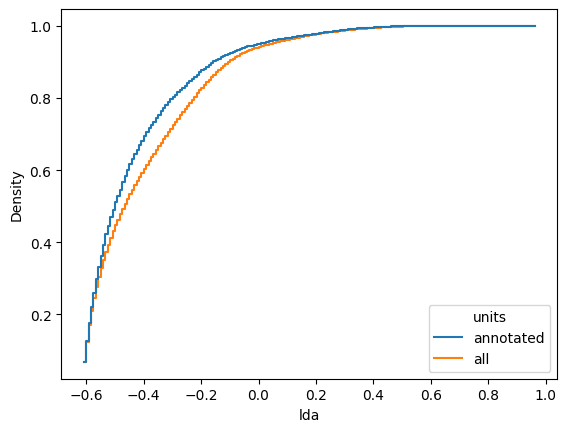

In [ ]:
import seaborn as sns

df = (
    get_df(ks4_filter=False)
    .drop_nulls('drift_rating')
    .join(lda_all_df.select('unit_id', 'lda'), on='unit_id', how='left')
    .select('lda')
    .with_columns(units=pl.lit('annotated'))
    .vstack(
        lda_all_df
        .select('lda')
        .with_columns(units=pl.lit('all'))
    )
    .fill_nan(None)
    .drop_nulls()
)

sns.histplot(df.to_pandas(), x='lda', hue='units', cumulative=True, stat='density', common_norm=False, element='step', fill=False);

In [ ]:
def fpr_to_lda_threshold(fpr_threshold: float) -> float:
    return (
        get_roc_curve_df(metric='lda')
        .select(
            pl.col('value').sort_by((pl.col('fpr') - fpr_threshold).abs())
        )
        .get_column('value')
        .first()
    )
    
def get_above_lda_threshold_df(df: pl.DataFrame, lda_threshold: float, drop_empty: bool = True) -> pl.DataFrame:
    return (
        df
        .with_columns(
            session_id=pl.col('unit_id').str.split('_').list.slice(0, 2).list.join('_'),
            subject_id=pl.col('unit_id').str.split('_').list.get(0),
        )
        .group_by('session_id')
        .agg(
            pl.col('subject_id').first(),
            above_threshold=pl.col('lda').ge(lda_threshold).sum().truediv(pl.col('lda').count()),
            n_units_with_lda_score=pl.col('lda').count(),
        )
        .filter(
            (pl.col('n_units_with_lda_score') > 0) if drop_empty else pl.lit(True)
        )
        .with_columns(
            subject_total_above_threshold=pl.col('above_threshold').sum().over('subject_id'),
        )
    )
    
def get_sessions_above_threshold_chart(df: pl.DataFrame, fpr_threshold: float) -> alt.Chart:
    lda_threshold = fpr_to_lda_threshold(fpr_threshold)
    return (
        alt.Chart(df.pipe(get_above_lda_threshold_df, lda_threshold=lda_threshold)).mark_bar().encode(
            color=alt.Color('above_threshold:Q'),#.scale(domain=[0, 1]),
            x=alt.X('subject_id:N', sort='x'),
            y=alt.Y('above_threshold:Q'),
            tooltip=['session_id', 'above_threshold'],
        ).properties(
            title=[f'Fraction of units above {lda_threshold=:.2f} (FPR={fpr_threshold})', '(some sessions missing LDA metric for all units)'],
            width=1600,
            height=200,
        )
        .interactive()
    )
    
def get_combined_above_threshold_chart(fpr_threshold: float, with_ks4_only: bool = False) -> alt.Chart:
    lda_threshold = fpr_to_lda_threshold(fpr_threshold)
    source = pl.concat(
        [
            # annotated ks2.5 units -------------------------------------------- #
            get_df(ks4_filter=False)
            .drop_nulls('drift_rating')
            .join(lda_all_df, on='unit_id', how='left')
            .pipe(get_above_lda_threshold_df, lda_threshold=lda_threshold)
            .with_columns(
                units_group=pl.lit('annotated_ks2.5'),
            ),
            # all ks2.5 units -------------------------------------------------- #
            lda_all_df
            .pipe(get_above_lda_threshold_df, lda_threshold=lda_threshold)
            .with_columns(
                units_group=pl.lit('predicted_ks2.5'),
            ),
            # all ks4 units ---------------------------------------------------- #
            lda_all_ks4_df
            .pipe(get_above_lda_threshold_df, lda_threshold=lda_threshold)
            .with_columns(
                units_group=pl.lit('predicted_ks4'),
            ),
        ]
    )
    if with_ks4_only:
        source = source.filter(pl.col('session_id').is_in(pl.col('session_id').filter(pl.col('units_group') == 'predicted_ks4')))
        
    order = ['annotated_ks2.5', 'predicted_ks2.5', 'predicted_ks4']
    assert all(name in source['units_group'].unique() for name in order)
    return (
        alt.Chart(source).mark_bar().encode(
            color=alt.Color('above_threshold:Q'),#.scale(domain=[0, 1]),
            x=alt.X('subject_id:N', sort='x'),
            y=alt.Y('above_threshold:Q'),
            order=alt.Order('session_id:N'),
            xOffset=alt.XOffset('units_group:N', sort=order),
            tooltip=['units_group', 'session_id', 'n_units_with_lda_score', 'above_threshold'],
        ).properties(
            title=[f'Fraction of units above {lda_threshold=:.2f} (FPR={fpr_threshold}) (some sessions missing LDA metric for units)', '', '{} units    |    {} (all units)    |    {} (all units)'.format(*order)],
            width=1800 if not with_ks4_only else 300,
            height=300,
        )
        .interactive()
    )

fpr_threshold = 0.2
get_combined_above_threshold_chart(
    fpr_threshold=fpr_threshold,
    with_ks4_only=True,
)

alt.Chart(...)

---
LDA in KS2.5 vs KS4

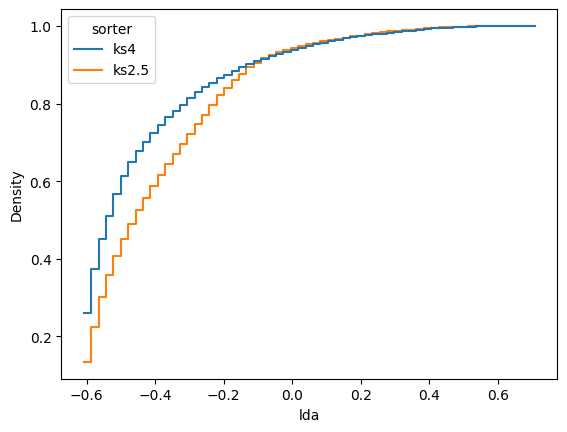

In [2]:
import seaborn as sns

metric = 'lda'

df = (
    lda_all_ks4_df
    .select(metric, 'unit_id')
    .with_columns(sorter=pl.lit('ks4'))
    .extend(
        lda_all_df
        .select(metric, 'unit_id')
        .with_columns(sorter=pl.lit('ks2.5'))
    )
    .fill_nan(None)
    .drop_nulls()
    .sort(metric)
    .with_columns(
        cdf=(pl.col(metric).cum_count() / pl.col(metric).count()).over('sorter'),
    )
    .with_columns(
        session_id=pl.col('unit_id').str.split('_').list.slice(0, 2).list.join('_'),
    )
    .filter(pl.col('session_id').is_in(pl.col('session_id').filter(pl.col('sorter') == 'ks4')))
)
sns.histplot(df.to_pandas(), x=metric, hue='sorter', cumulative=True, stat='density', common_norm=False, element='step', fill=False);

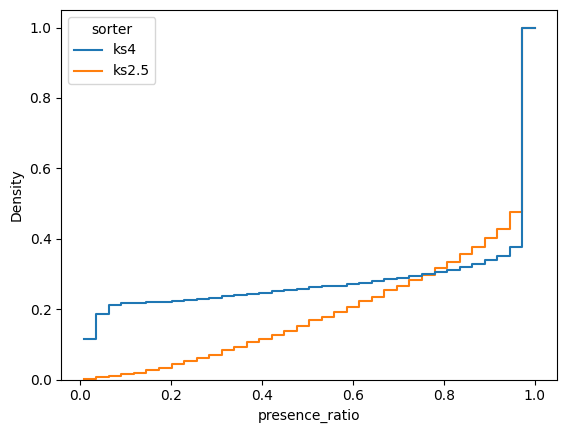

In [3]:
import seaborn as sns

metric = 'presence_ratio'
df = (
    pl.scan_parquet("s3://aind-scratch-data/dynamic-routing/unit-rasters-ks4/units.parquet")
    .select('unit_id', metric) 
    .with_columns(sorter=pl.lit('ks4'))
    .collect()
    .extend(
        pl.scan_parquet("s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.261/consolidated/units.parquet")
        .select('unit_id', metric)
        .drop_nans(metric)
        .with_columns(sorter=pl.lit('ks2.5'))
        .collect()
    )
    .with_columns(
        session_id=pl.col('unit_id').str.split('_').list.slice(0, 2).list.join('_'),
    )
    .filter(pl.col('session_id').is_in(pl.col('session_id').filter(pl.col('sorter') == 'ks4')))
)
sns.histplot(df.to_pandas(), x=metric, hue='sorter', cumulative=True, stat='density', common_norm=False, element='step', fill=False);

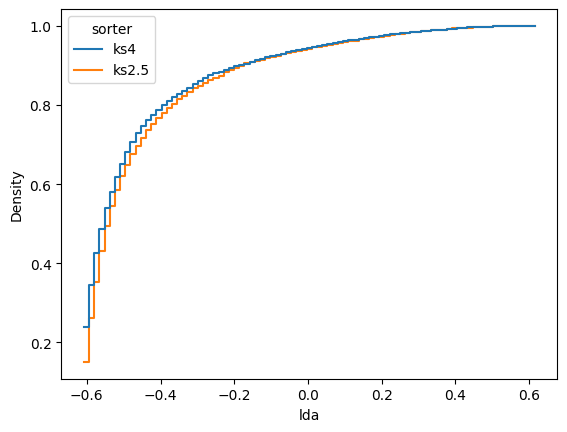

In [27]:
import seaborn as sns

metric = 'lda'

df = (
    lda_all_ks4_df
    .select(metric, 'unit_id')
    .with_columns(sorter=pl.lit('ks4'))
    .extend(
        lda_all_df
        .select(metric, 'unit_id')
        .with_columns(sorter=pl.lit('ks2.5'))
    )
    .join(
        other=(
            pl.concat([
                pl.scan_parquet(KS4_UNITS_DF_PATH).select('unit_id', 'presence_ratio').collect(),
                pl.scan_parquet("s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.261/consolidated/units.parquet").select('unit_id', 'presence_ratio').collect(),   
            ])
        ),
        on='unit_id',
        how='left',
    )
    .fill_nan(None)
    .drop_nulls()
    .filter(pl.col('presence_ratio') > 0.9)
    .with_columns(
        session_id=pl.col('unit_id').str.split('_').list.slice(0, 2).list.join('_'),
    )
    .filter(pl.col('session_id').is_in(pl.col('session_id').filter(pl.col('sorter') == 'ks4')))
)
sns.histplot(df.to_pandas(), x=metric, hue='sorter', cumulative=True, stat='density', common_norm=False, element='step', fill=False);

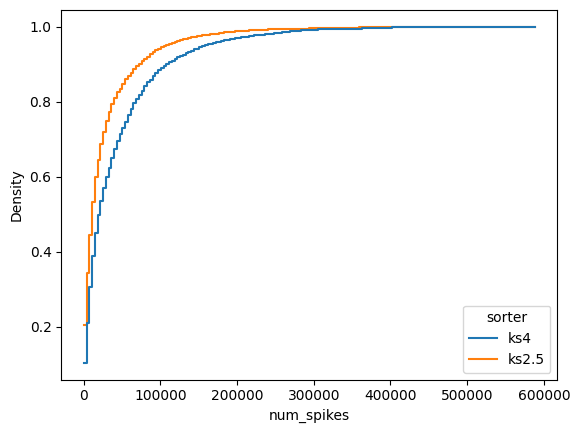

In [33]:

import seaborn as sns

metric = 'num_spikes'

df = (
    pl.scan_parquet("s3://aind-scratch-data/dynamic-routing/unit-rasters-ks4/units.parquet")
    .select('unit_id', metric) 
    .with_columns(sorter=pl.lit('ks4'))
    .collect()
    .extend(
        pl.scan_parquet("s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.261/consolidated/units.parquet")
        .select('unit_id', metric)
        .drop_nans(metric)
        .cast({metric: pl.Int64})
        .with_columns(sorter=pl.lit('ks2.5'))
        .collect()
    )
    .join(
        other=(
            pl.concat([
                pl.scan_parquet(KS4_UNITS_DF_PATH).select('unit_id', 'presence_ratio').collect(),
                pl.scan_parquet("s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.261/consolidated/units.parquet").select('unit_id', 'presence_ratio').collect(),   
            ])
        ),
        on='unit_id',
        how='left',
    )
    .fill_nan(None)
    .drop_nulls()
    .filter(pl.col('presence_ratio') > 0.9)
    .with_columns(
        session_id=pl.col('unit_id').str.split('_').list.slice(0, 2).list.join('_'),
    )
    .filter(pl.col('session_id').is_in(pl.col('session_id').filter(pl.col('sorter') == 'ks4')))
)
sns.histplot(df.to_pandas(), x=metric, hue='sorter', cumulative=True, stat='density', common_norm=False, element='step', fill=False);

In [16]:
pl.scan_parquet("s3://aind-scratch-data/dynamic-routing/unit-rasters-ks4/units.parquet").schema

C:\Users\ben.hardcastle\AppData\Local\Temp\ipykernel_20792\832720853.py:1: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  pl.scan_parquet("s3://aind-scratch-data/dynamic-routing/unit-rasters-ks4/units.parquet").schema


Schema([('sync_spike_2', Float64),
        ('sync_spike_8', Float64),
        ('amplitude_cv_median', Float64),
        ('isolation_distance', Float64),
        ('rp_violations', Int64),
        ('rp_contamination', Float64),
        ('nn_miss_rate', Float64),
        ('sliding_rp_violation', Float64),
        ('presence_ratio', Float64),
        ('snr', Float64),
        ('peak_trough_ratio', Float64),
        ('shank', String),
        ('isi_violations_count', Int64),
        ('peak_to_valley', Float64),
        ('depth', Float64),
        ('firing_rate', Float64),
        ('firing_range', Float64),
        ('amplitude_cv_range', Float64),
        ('amplitude', Float64),
        ('velocity_below', Float64),
        ('repolarization_slope', Float64),
        ('estimated_y', Float64),
        ('original_cluster_id', Int64),
        ('d_prime', Float64),
        ('velocity_above', Float64),
        ('decoder_label', String),
        ('ks_unit_id', Int64),
        ('spread', Int64),
    